## Import the libraries

In [ ]:
from IPython.display import Image as ImageDisplay
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa

## Enable the TPU cluster

In [ ]:
# Enable the TPU cluster resolver.
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

## Import the Dataset
#### Requires turning on the Internet on the Settings tab to work.

In [ ]:
KAGGLE_GCS_PATH = KaggleDatasets().get_gcs_path()

In [ ]:
MONET_TFREC_IMAGE_FILES = tf.io.gfile.glob(str(KAGGLE_GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTOGRAPH_TFREC_IMAGE_FILES = tf.io.gfile.glob(str(KAGGLE_GCS_PATH + '/photo_tfrec/*.tfrec'))

print("TFREC Records for Monet Images: %s" % len(MONET_TFREC_IMAGE_FILES))
print("TFREC Records for Photograph Images: %s" % len(PHOTOGRAPH_TFREC_IMAGE_FILES))

## Image Helper functions

In [ ]:
DATASET_IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*DATASET_IMAGE_SIZE, 3])
    return image

def tfrecord_read(sample):
    tfrecord_format = {"image_name": tf.io.FixedLenFeature([], tf.string),
                       "image": tf.io.FixedLenFeature([], tf.string),
                       "target": tf.io.FixedLenFeature([], tf.string)}
    sample = tf.io.parse_single_example(sample, tfrecord_format)
    image = decode_image(sample["image"])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(tfrecord_read, num_parallel_calls=AUTOTUNE)
    return dataset

## Load the Dataset for the Model
#### The format are tfrecords which can be cycled through an iterator. Unlike other methods, you cannot determine the length of the records without iterating through all the records.

In [ ]:
monet_images_dataset = load_dataset(MONET_TFREC_IMAGE_FILES, labeled = True).batch(1)
photographs_images_dataset = load_dataset(PHOTOGRAPH_TFREC_IMAGE_FILES, labeled = True).batch(1)

In [ ]:
num_records_monet = sum(1 for record in monet_images_dataset)
num_records_photographs = sum(1 for record in photographs_images_dataset)
print("# of monet images to train with: %s" % num_records_monet)
print("# of photographs to predict: %s" % num_records_photographs)

There are more photographs for the prediction than there are monet images. This is good, as the photographs transformations will be very useful in training and validating. The monet images are mostly for the model to learn patterns from and apply the transformation to the photos

## View a sample of the Dataset
#### Iterate through some of the records and show a pyplot

In [ ]:
sample_monet_image = next(iter(monet_images_dataset))
sample_photograph_image = next(iter(photographs_images_dataset))

plt.subplot(1,2,1)
plt.title("Photograph")
plt.imshow((sample_photograph_image[0] * 0.5) + 0.5)
plt.subplot(1,2,2)
plt.title("Monet Artwork")
plt.imshow((sample_monet_image[0] * 0.5) + 0.5)

## Custom layers for the GAN Model (downsampling, upsampling, Reflection Padding)

#### Define the initializers used to feed the functions below 

In [ ]:
# Weights initializer for the layers.
kernel_weights_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Gamma initializer for instance normalization.
gamma_normalization_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

#### Define the Downsampling, Upsampling and ConstantPadding2D layers

In [ ]:
class PaddingConstant2D(layers.Layer):
    '''Implements a Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    '''
    
    def __init__(self, padding = (1,1), **kwargs):
        self.padding = padding
        super(PaddingConstant2D, self).__init__(**kwargs)
        
    def call(self, input_tensor, mask = None):
        padding_width, padding_height = self.padding
        padding_tensor = [[0,0], [padding_height, padding_height], [padding_width, padding_width], [0,0]]
        return tf.pad(input_tensor, padding_tensor, mode="CONSTANT")

def downsampling_layers(model_layers, filters, activation, kernel_initializer=kernel_weights_initializer, kernel_size=(3,3),
                        strides=(2,2), padding="same", gamma_initializer=gamma_normalization_initializer, use_bias=False):
    # Conv2D -> Activation (optional)
    model_layers = layers.Conv2D(filters, kernel_size, strides=strides, kernel_initializer=kernel_initializer,
                                 padding=padding, use_bias=use_bias)(model_layers)
    
    if activation:
        model_layers = activation(model_layers)
    return model_layers

def upsampling_layers(model_layers, filters, activation, kernel_initializer=kernel_weights_initializer, kernel_size=(3,3),
                      strides=(2,2), padding="same", gamma_initializer=gamma_normalization_initializer, use_bias=False):
    # Conv2DTranspose -> Normalization -> Activation (optional)
    model_layers = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding, 
                                          kernel_initializer=kernel_initializer, use_bias=use_bias)(model_layers)
    model_layers = tfa.layers.InstanceNormalization(gamma_initializer = gamma_initializer)(model_layers)
    
    if activation:
        model_layers = activation(model_layers)
    return model_layers

def residual_block_layers(model_layers, activation, kernel_initializer=kernel_weights_initializer,
                          kernel_size=(3,3), strides=(1,1), padding="valid",
                          gamma_initializer=gamma_normalization_initializer, use_bias=False):
    input_tensor = model_layers
    num_output_filters = model_layers.shape[-1]

    # Append all the layers here.
    model_layers = PaddingConstant2D()(input_tensor)
    model_layers = layers.Conv2D(num_output_filters, kernel_size, strides=strides, kernel_initializer=kernel_initializer,
                                 padding=padding, use_bias=use_bias)(model_layers)
    model_layers = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(model_layers)
    model_layers = activation(model_layers)
    model_layers = PaddingConstant2D()(model_layers)
    model_layers = layers.Conv2D(num_output_filters, kernel_size, strides=strides, kernel_initializer=kernel_initializer,
                                 padding=padding, use_bias=use_bias)(model_layers)
    model_layers = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(model_layers)
    model_layers = layers.add([input_tensor, model_layers])
    return model_layers

## Build the Generator and Discriminator Models

In [ ]:
#-------------- Generator Model
def generator_model(filters=64, num_downsampling_blocks=2, num_residual_blocks=9, num_upsampling_blocks=2,
                    kernel_initializer=kernel_weights_initializer, gamma_initializer=gamma_normalization_initializer,
                    name=None):
    image_layer_name = name + "_image_input"
    image_input = layers.Input(shape=(256,256,3), name=image_layer_name)

    # Define the Relu activation layer.
    relu_activation_layer = layers.Activation("relu")
    
    model_layers = PaddingConstant2D(padding=(3,3))(image_input)
    model_layers = layers.Conv2D(filters, (7,7), kernel_initializer=kernel_initializer, use_bias=False)(model_layers)
    model_layers = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(model_layers)
    model_layers = relu_activation_layer(model_layers)
    
    # Add Downsampling layers
    for _ in range(num_downsampling_blocks):
        filters *= 2
        model_layers = downsampling_layers(model_layers, filters=filters, activation=relu_activation_layer)
        
    # Add Residual block layers
    for _ in range(num_residual_blocks):
        model_layers = residual_block_layers(model_layers, activation=relu_activation_layer)
        
    # Add Upsampling layers
    for _ in range(num_upsampling_blocks):
        filters //= 2
        model_layers = upsampling_layers(model_layers, filters=filters, activation=relu_activation_layer)
        
    # Final layers with Tanh activation.
    model_layers = PaddingConstant2D(padding=(3,3))(model_layers)
    model_layers = layers.Conv2D(3, (7,7), padding="valid")(model_layers)
    model_layers = layers.Activation("tanh")(model_layers)
    
    model = keras.models.Model(image_input, model_layers, name=name)
    return model


#-------------- Discriminator Model
def discriminator_model(filters=64, kernel_initializer=kernel_weights_initializer, num_downsampling=3, name=None):
    image_layer_name = name + "_image_input"
    image_input = layers.Input(shape=(256,256,3), name=image_layer_name)
    
    # Define the leaky relu activation layer.
    leaky_relu_activation_layer = layers.LeakyReLU(0.2)
    
    # Add a convolution layer with 2x2 strides followed by a leaky relu activation layer.
    model_layers = layers.Conv2D(filters, (4,4), strides=(2,2), padding="same", 
                                 kernel_initializer=kernel_initializer)(image_input)
    model_layers = leaky_relu_activation_layer(model_layers)
    
    # Add Downsampling layers.
    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            model_layers = downsampling_layers(model_layers, filters=num_filters, activation=leaky_relu_activation_layer,
                                               kernel_size=(4,4), strides=(2,2))
        else:
            model_layers = downsampling_layers(model_layers, filters=num_filters, activation=leaky_relu_activation_layer,
                                               kernel_size=(4,4),strides=(1,1))

    # Finally add the convolution layer with 1x2 stride at the end of the model.
    model_layers = layers.Conv2D(1, (4,4), strides=(1,1), padding="same",
                                 kernel_initializer=kernel_initializer)(model_layers)
    model = keras.models.Model(image_input, model_layers, name = name)
    return model

## Enable the TPU on the Generator and Discriminator Models and Model Optimizers

In [ ]:
with strategy.scope():
    # Define the generator and discriminator models
    monet_generator = generator_model(name="generator_monet")  # Transforms photos to monet
    photo_generator = generator_model(name="generator_photo")  # Transforms monet to photos
    monet_discriminator = discriminator_model(name="discriminator_monet") # Differentiates real monets and generated monets
    photo_discriminator = discriminator_model(name="discriminator_photo") # Differentiates real photos and generated photos
    
    # Define the optimizers for the models.
    monet_generator_optimizer = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
    photo_generator_optimizer = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
    monet_discriminator_optimizer = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
    photo_discriminator_optimizer = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

In [ ]:
converted_monet_image = monet_generator(sample_photograph_image)

plt.subplot(1,2,1)
plt.title("Original Photograph")
plt.imshow((sample_photograph_image[0] * 0.5) + 0.5)
plt.subplot(1,2,2)
plt.title("Generate Monet Artwork")
plt.imshow((converted_monet_image[0] * 0.5) + 0.5)

We can see that the model is initialized and ready to be trained.

## Build the Loss Functions to be ran on the TPU

In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
        loss_real = keras.losses.BinaryCrossentropy(from_logits=True,
                                                    reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        loss_fake = keras.losses.BinaryCrossentropy(from_logits=True,
                                                    reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_discriminator_loss = (loss_real + loss_fake) * 0.5
        return total_discriminator_loss    

    def generator_loss(generated):
        gen_loss = keras.losses.BinaryCrossentropy(from_logits=True,
                                                   reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
        return gen_loss

    def cycle_loss(real_image, cycled_image, lamda):
        loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        cyc_loss = loss * lamda
        return cyc_loss

    def identity_loss(real_image, same_image, lamda1, lamda2):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        id_loss = loss * lamda1 * lamda2
        return id_loss

## Build the CycleGAN Model

In [ ]:
class CycleGAN(keras.Model):
    def __init__(self, monet_generator, photo_generator,
                 monet_discriminator, photo_discriminator,
                 lambda_cycle=10.0, lambda_identity=0.5):
        super(CycleGAN, self).__init__()
        self.monet_generator = monet_generator
        self.photo_generator = photo_generator
        self.monet_discriminator = monet_discriminator
        self.photo_discriminator = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity
        
    def compile(self, monet_generator_optimizer, photo_generator_optimizer,
                monet_discriminator_optimizer, photo_discriminator_optimizer,
                generator_loss_function, discriminator_loss_function,
                cycle_loss_function, identity_loss_function):
        super(CycleGAN, self).compile()
        self.monet_generator_optimizer = monet_generator_optimizer
        self.photo_generator_optimizer = photo_generator_optimizer
        self.monet_discriminator_optimizer = monet_discriminator_optimizer
        self.photo_discriminator_optimizer = photo_discriminator_optimizer
        self.generator_loss = generator_loss_function
        self.discriminator_loss = discriminator_loss_function
        self.cycle_loss = cycle_loss_function
        self.identity_loss = identity_loss_function
    
    # The naming convention below is shared by keras.Model per epoch.
    def train_step(self, batch):
        monet_real, photo_real = batch
        
        with tf.GradientTape(persistent=True) as tape:
            # photo --> monet --> photo
            monet_fake = self.monet_generator(photo_real, training=True)
            photo_cycled = self.photo_generator(monet_fake, training=True)
            
            # monet --> photo --> monet
            photo_fake = self.photo_generator(monet_real, training=True)
            monet_cycled = self.monet_generator(photo_fake, training=True)
            
            # Identity mapping. Attempt to reproduce the same source image for model accuracy comparison.
            monet_approximate = self.monet_generator(monet_real, training=True)
            photo_approximate = self.photo_generator(photo_real, training=True)
            
            # Discriminator outputs used for training.
            discriminator_monet_real = self.monet_discriminator(monet_real, training=True)
            discriminator_monet_fake = self.monet_discriminator(monet_fake, training=True)
            discriminator_photo_real = self.photo_discriminator(photo_real, training=True)
            discriminator_photo_fake = self.photo_discriminator(photo_fake, training=True)
            
            # Generator cycle losses
            monet_cycled_loss = self.cycle_loss(monet_real, monet_cycled, self.lambda_cycle)
            photo_cycled_loss = self.cycle_loss(photo_real, photo_cycled, self.lambda_cycle)
            total_cycle_loss = monet_cycled_loss + photo_cycled_loss
            
            # Generator losses for the discriminator fake outputs.
            monet_generator_loss = self.generator_loss(discriminator_monet_fake)
            photo_generator_loss = self.generator_loss(discriminator_photo_fake)
            
            # Identity losses
            monet_identity_loss = self.identity_loss(monet_real, monet_approximate,
                                                     self.lambda_cycle, self.lambda_identity)
            photo_identity_loss = self.identity_loss(photo_real, photo_approximate,
                                                     self.lambda_cycle, self.lambda_identity)
            total_identity_loss = monet_identity_loss + photo_identity_loss
            
            # Total generator losses
            total_monet_generator_loss = monet_generator_loss + total_cycle_loss + total_identity_loss
            total_photo_generator_loss = photo_generator_loss + total_cycle_loss + total_identity_loss
            
            # Discriminator losses
            monet_discriminator_loss = self.discriminator_loss(discriminator_monet_real, discriminator_monet_fake)
            photo_discriminator_loss = self.discriminator_loss(discriminator_photo_real, discriminator_photo_fake)
        
        # Calculate Gradients for Generator and Discriminators.
        monet_generator_gradients = tape.gradient(total_monet_generator_loss,
                                                  self.monet_generator.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_generator_loss,
                                                  self.photo_generator.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_discriminator_loss,
                                                      self.monet_discriminator.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_discriminator_loss,
                                                      self.photo_discriminator.trainable_variables)
        
        self.monet_generator_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                           self.monet_generator.trainable_variables))
        self.photo_generator_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                           self.photo_generator.trainable_variables))
        self.monet_discriminator_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                               self.monet_discriminator.trainable_variables))
        self.photo_discriminator_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                               self.photo_discriminator.trainable_variables))
        
        return {'monet_gen_loss': total_monet_generator_loss,
                'photo_gen_loss': total_photo_generator_loss,
                'monet_disc_loss': monet_discriminator_loss,
                'photo_disc_loss': photo_discriminator_loss}

## Compile the CycleGAN Model to run on the TPU

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGAN(monet_generator, photo_generator, monet_discriminator, photo_discriminator)
    cycle_gan_model.compile(monet_generator_optimizer=monet_generator_optimizer,
                            photo_generator_optimizer=photo_generator_optimizer,
                            monet_discriminator_optimizer=monet_discriminator_optimizer,
                            photo_discriminator_optimizer=photo_discriminator_optimizer,
                            generator_loss_function=generator_loss,
                            discriminator_loss_function=discriminator_loss,
                            cycle_loss_function=cycle_loss,
                            identity_loss_function=identity_loss)

## Train the CycleGAN Model with 50 epochs
The model fitting will be stuck at Epoch 1/50 for sometime while loading to the TPU, after sometime, the TPU will kickstart and the training will begin.

With the TPU, each epoch takes approximately 2 minutes. This means 50 epochs takes about 120 minutes or about 2 hours.

In [ ]:
history = cycle_gan_model.fit(tf.data.Dataset.zip((monet_images_dataset, photographs_images_dataset)),
                              epochs=2)

## Visualize the Predictions from the monet_generator

In [ ]:
# Show 10 photographs transformed to Monet artworks.
_, axes = plt.subplots(10, 2, figsize=(20,20))
for idx, photo_image in enumerate(photographs_images_dataset.take(10)):
    # Make sure training=False so that we don't affect the trained generator.
    monet_of_photo = monet_generator(photo_image, training=False)[0].numpy()
    
    # Scale the Monet generated output and input photograph.
    monet_of_photo = (monet_of_photo * 0.5) + 0.5
    photo_image = ((photo_image[0] * 0.5) + 0.5).numpy()
    
    # Show the comparison images.
    axes[idx, 0].imshow(photo_image)
    axes[idx, 1].imshow(monet_of_photo)
    axes[idx, 0].set_title("Photograph Input")
    axes[idx, 1].set_title("Generated Monet Output")
    axes[idx, 0].axis("off")
    axes[idx, 1].axis("off")

plt.tight_layout()
plt.show()

## Visualize the Architecture of the Full Model

In [ ]:
plot_model(cycle_gan_model, to_file='monet_cycleGAN_model.png', show_shapes=True, show_layer_names=True)

The model is special in that the layers are added in a custom way that isn't just adding layers to the model. For instance, the model trains the discriminator and generator models in each step, updating the gradients of the optimizer based on the losses calculated from the generator and discriminator models.

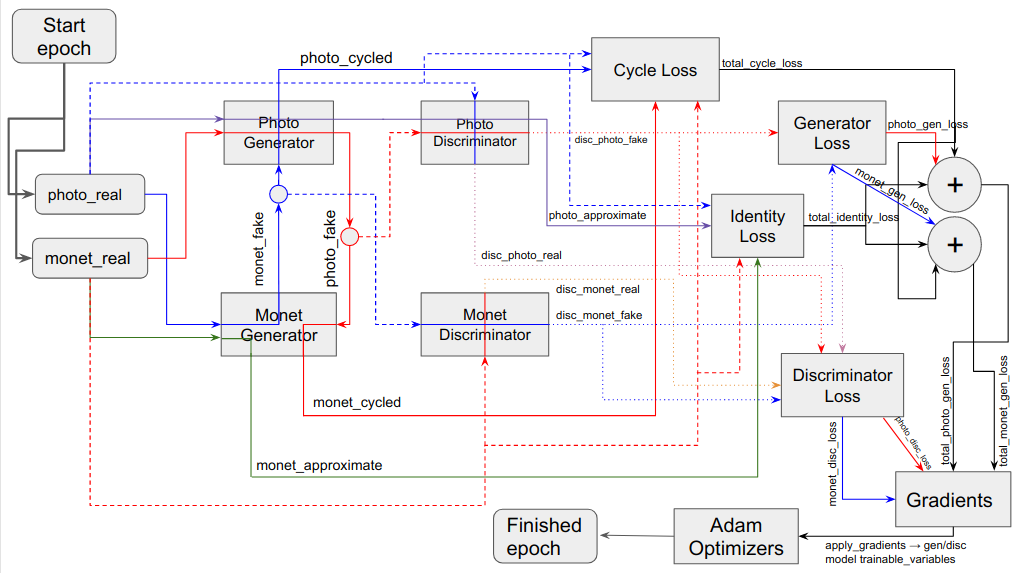

## Visualize the Architectures of the Generator and Discriminator Models

In [ ]:
plot_model(monet_generator, to_file='cycleGAN_generator_monet.png', show_shapes=True, show_layer_names=True)

In [ ]:
plot_model(monet_discriminator, to_file='cycleGAN_discriminator_monet.png', show_shapes=True, show_layer_names=True)